In [1]:
library(tidyr)
library(plyr)
library(dplyr)
library(ggplot2)
source("../utils/helper_functions.r")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
✔ purrr   0.3.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks ply

In [2]:
# Combine all nsim=150 simulations
sims = list.files(path = "../04_distilbert/evaluation/", pattern="^marginal_metrics", full.names = TRUE)
nsim = length(sims)
dfs = lapply(sims, read.csv)
dfs = lapply(1:length(dfs), function(i) {
    df = dfs[[i]]
    df = rename(df, concern=X)
    df$sim = i
    return(df)
})

df = bind_rows(dfs)
print(dim(df))
print(nsim)

[1] 1950   12
[1] 150


# Marginal metrics

In [3]:
# Back-out per-label accuracies
df = df %>% mutate(accuracy = (true0_pred0 + true1_pred1) / (true0_pred0 + true1_pred1 + true0_pred1 + true1_pred0))

In [4]:
# Create metrics table
means = df %>% select(concern, accuracy, precision, recall, f1.score) %>% 
        group_by(concern) %>% 
        summarize(mean_accuracy = round(mean(accuracy), 2),
                  se_accuracy = round(sd(accuracy)/sqrt(nsim), 3),
                  min_accuracy = round(min(accuracy), 2),
                  max_accuracy = round(max(accuracy), 2),
                  mean_precision = round(mean(precision), 2),
                  se_precision = round(sd(precision)/sqrt(nsim), 3),
                  min_precision = round(min(precision), 2),
                  max_precision = round(max(precision), 2),
                  mean_recall = round(mean(recall), 2),
                  se_recall = round(sd(recall)/sqrt(nsim), 3),
                  min_recall = round(min(recall), 2),
                  max_recall = round(max(recall), 2),
                  mean_f1 = round(mean(f1.score), 2),
                  se_f1 = round(sd(f1.score)/sqrt(nsim), 3),
                  min_f1 = round(min(f1.score), 2),
                  max_f1 = round(max(f1.score), 2)) %>%
        arrange(desc(mean_f1))

In [5]:
means %>% select(concern, mean_f1, mean_precision, mean_recall) #se_accuracy, se_f1, se_precision, se_recall

concern,mean_f1,mean_precision,mean_recall
<chr>,<dbl>,<dbl>,<dbl>
Availability,0.93,0.93,0.93
EnforceUse,0.93,0.93,0.93
NotWornE,0.91,0.91,0.91
WornIncorrectlyE,0.89,0.93,0.87
FitTest,0.87,0.93,0.84
EnforceCorrectUse,0.83,0.93,0.78
NotWornNE,0.79,0.90,0.73
PPEDiscouragedProhibited,0.74,0.87,0.69
NotWornU,0.71,0.82,0.66


In [6]:
df_means = means %>% select(concern, mean_f1, mean_precision, mean_recall) %>% 
pivot_longer(cols = c(mean_f1, mean_precision, mean_recall), names_to = "Type", values_to = "Score")

In [7]:
df_ses = means %>% select(concern, se_accuracy, se_f1, se_precision, se_recall)
df_ses

concern,se_accuracy,se_f1,se_precision,se_recall
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Availability,0.001,0.001,0.001,0.001
EnforceUse,0.001,0.001,0.001,0.001
NotWornE,0.001,0.001,0.001,0.001
WornIncorrectlyE,0.000,0.003,0.003,0.004
FitTest,0.000,0.004,0.004,0.005
EnforceCorrectUse,0.000,0.004,0.004,0.005
NotWornNE,0.000,0.004,0.004,0.004
PPEDiscouragedProhibited,0.000,0.005,0.007,0.005
NotWornU,0.000,0.005,0.006,0.004


In [8]:
label_order = means %>% arrange(desc(mean_f1)) %>% select(concern) %>% unlist
names(label_order) = NULL

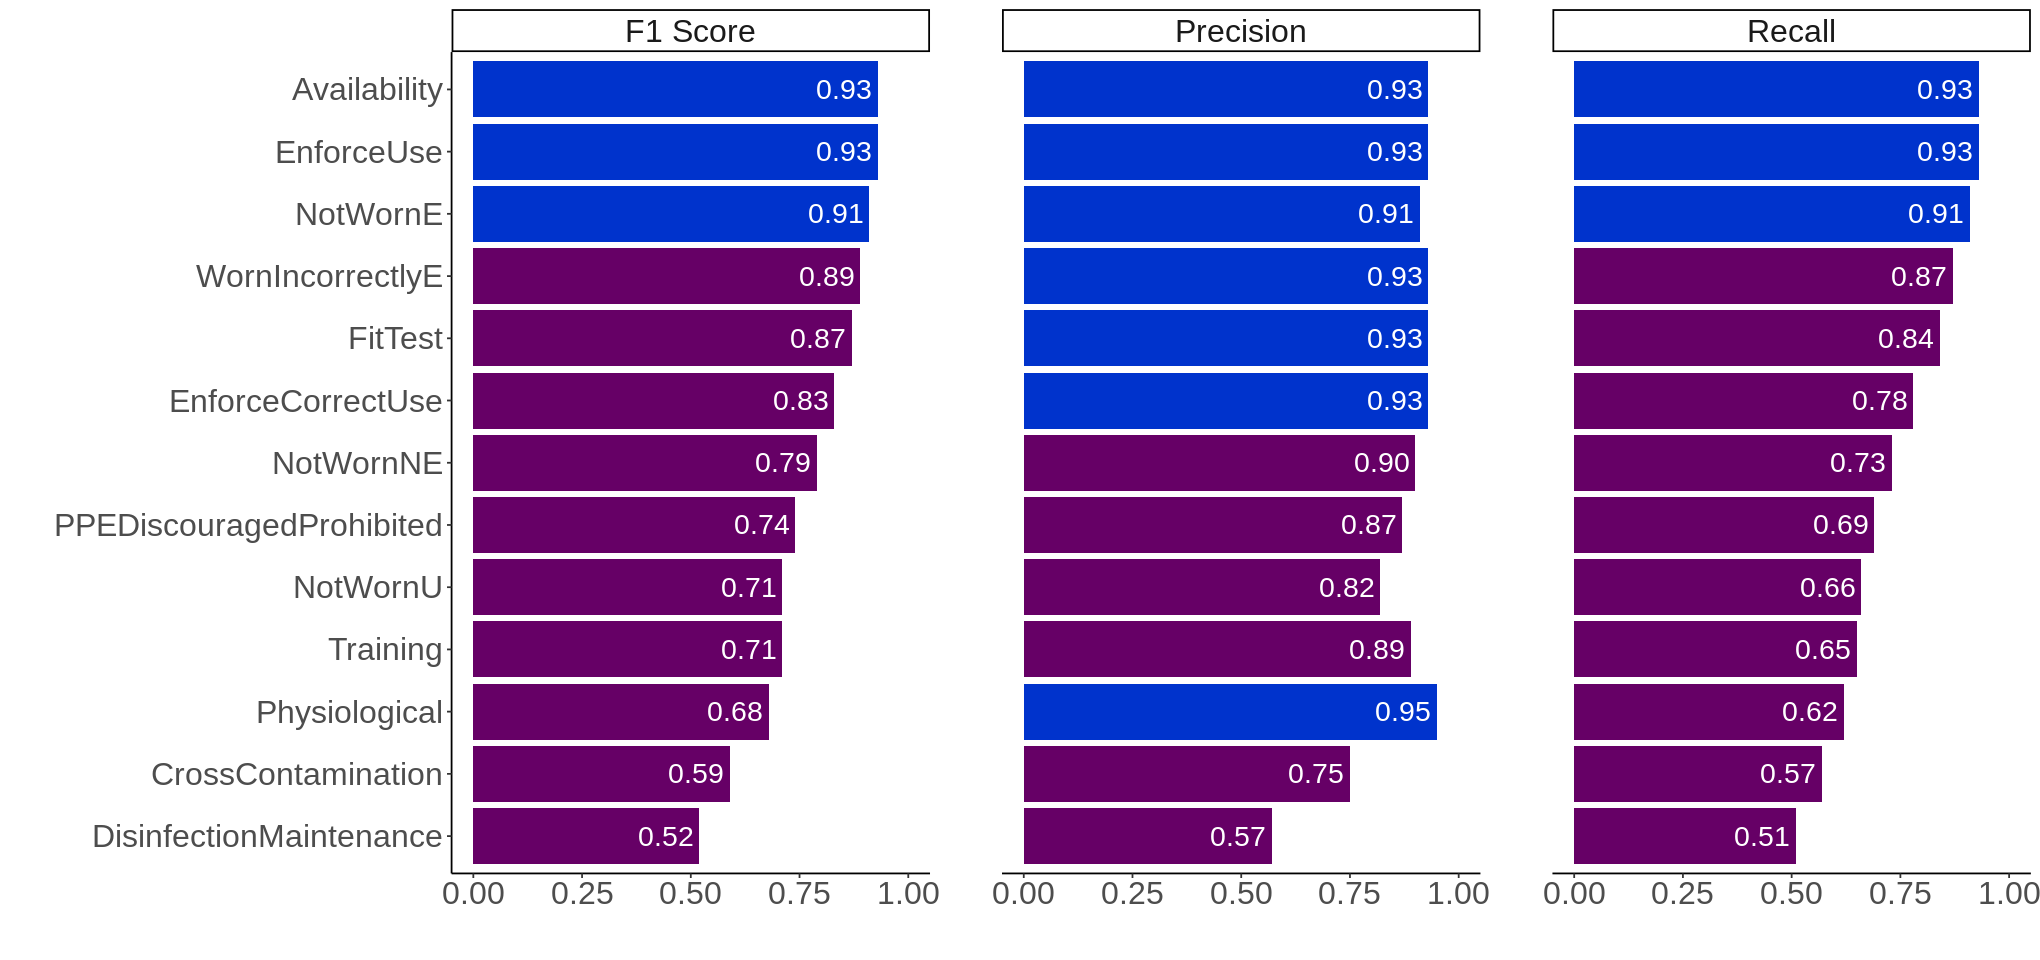

In [9]:
options(repr.plot.width=17, repr.plot.height=8)
df_means %>% mutate(
    Type = recode(Type, mean_f1="F1 Score", mean_precision="Precision", mean_recall = "Recall"),
    Concern = concern,
    concern = NULL
) %>%
mutate(Concern = factor(Concern, levels = rev(label_order))) %>%
ggplot(aes(x = Score, y = Concern)) +
geom_bar(stat="identity", aes(fill = Score > 0.9)) + 
scale_fill_manual(values = c("#660066", "#0033cc")) +
facet_wrap(.~Type) +
xlim(0, 1) +
theme_classic() +
ylab("") +
xlab("") +
geom_text(aes(label= format(round(Score, digits = 2), nsmall = 2) ), hjust=1.1, color="white", position = position_dodge(0.9), size=6) +
theme(text = element_text(size = 24), panel.spacing = unit(3, "lines")) +
guides(fill="none")

# Overall metrics

In [10]:
metrics = list.files(path = "../04_distilbert/evaluation/", pattern="^overall_metrics", full.names = TRUE)
dfs = lapply(metrics, read.csv)
df = join_all(dfs, by = "X", type = "left")
print(dim(df))

[1]   9 151


In [11]:
new_colnames = df[,1]
overall = t(df[,-1])
row.names(overall) = NULL
colnames(overall) = new_colnames

In [12]:
overall %>% colMeans %>% as.matrix %>% as_tibble()

test_loss,0.08590708
test_f1_micro,0.84707664
test_f1_macro,0.57257977
test_roc_auc_micro,0.90208762
test_roc_auc_macro,0.74604323
test_accuracy,0.75108835
test_runtime,9.92212267
test_samples_per_second,79.58628667
test_steps_per_second,4.99323333


In [13]:
overall %>% apply(., 2, function(x) sd(x)/sqrt(nrow(overall))) %>% as.matrix %>% as_tibble()

test_loss,0.0005070808
test_f1_micro,0.0008536269
test_f1_macro,0.0024968462
test_roc_auc_micro,0.0005712593
test_roc_auc_macro,0.0012054945
test_accuracy,0.0012433222
test_runtime,0.1228747000
test_samples_per_second,0.5273479505
test_steps_per_second,0.0330837395


# Trend analyses

## Combine OOS predictions with manually assigned labels

In [14]:
# Majority vote predictions on OOS complaints
# - Merges df with sample info (NAICS, etc.)
# - Includes all complaints - study sample AND oos.
# - Creates a new variable that can be used to filter for study sample OR oos as desired.
# - Writes csv file

labels = c('Availability', 'EnforceUse', 'NotWornE', 'WornIncorrectlyE', 
           'NotWornNE', 'NotWornU', 'EnforceCorrectUse', 'CrossContamination',
           'PPEDiscouragedProhibited', 'Training', 'FitTest', 'Physiological',
           'DisinfectionMaintenance')

p0 = prep_osha_R("../04_distilbert/predict_oos_m0/ppe_unsampled_preds.csv")
p1 = prep_osha_R("../04_distilbert/predict_oos_m1/ppe_unsampled_preds.csv")
p2 = prep_osha_R("../04_distilbert/predict_oos_m2/ppe_unsampled_preds.csv")

p0 = p0 %>% mutate_at(labels, as.logical)
p1 = p1 %>% mutate_at(labels, as.logical)
p2 = p2 %>% mutate_at(labels, as.logical)

rowwise_majority_vote = function(x) {
    y = apply(x, 1, function(v) {
        majority_vote = names(sort(table(v), decreasing=TRUE))[1]
        majority_vote = as.logical(majority_vote)
        return(majority_vote)
    })
    return(y)
}

votes = sapply(labels, function(label) {
    x0 = p0[,label]
    x1 = p1[,label]
    x2 = p2[,label]
    x = bind_cols(pred0=x0, pred1=x1, pred2=x2)
    y = rowwise_majority_vote(x)
    return(y)
})

votes = as.data.frame(votes)

# p0 will contain OOS predictions for OOS complaints
p0[,labels] = votes

[1] 27818    42
[1] 27818    42
[1] 27818    42


In [15]:
# Map labels for distinct narratives back to study sample
ppe_sample = prep_osha_R("../02_sample-data/ppe_sample.csv")
ml = read.csv("../03_ppe-coding/ml_dataset.csv") %>% select(all_of(c('Hazard.Desc.Loc.lt', labels)))
study_sample = left_join(ppe_sample, ml, by="Hazard.Desc.Loc.lt")

[1] 3200   28


In [16]:
binarize = function(x) (ifelse(x=='', 0, 1))
study_sample = study_sample %>% mutate_at(labels, binarize)

In [17]:
# Combine manually labeled sampled complaints + ML labeled OOS complaints
keep_cols = intersect(colnames(study_sample), colnames(p0))
ppe_labeled = bind_rows(
    study_sample %>% select(all_of(keep_cols)),
    p0 %>% select(all_of(keep_cols))
)
print(dim(ppe_labeled))

[1] 31018    41


In [18]:
write.csv(ppe_labeled, "../04_distilbert/ppe_labeled.csv", row.names = FALSE)